In [1]:
import numpy as np
import pandas as pd
import random
import math
import seaborn as sns
import matplotlib.pyplot as plt
import math
np.set_printoptions(precision=1,suppress=True)
%matplotlib inline
import matplotlib
%config InlineBackend.figure_format = 'jpg'
matplotlib.figure.Figure.__repr__ = lambda self: (
    f"<{self.__class__.__name__} size {self.bbox.size[0]:g}"
    f"x{self.bbox.size[1]:g} with {len(self.axes)} Axes>")
import matplotlib.pyplot as plt
plt.style.use('PR.mplstyle')

In [2]:
from scipy.stats import t as student
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
random.seed(42)
np.random.seed(42)

In [3]:
dfBeers = pd.read_csv('data/beers.csv')
dfBrewers = pd.read_csv('data/breweries.csv')

dfBeers = dfBeers.rename(columns={'Unnamed: 0' : 'rowNum'})
dfBrewers = dfBrewers.rename(columns={'Unnamed: 0' : 'brewery_id'})

#striping whitespaces
dfBeers['name'] = dfBeers['name'].str.strip()
dfBeers['style'] = dfBeers['style'].str.strip()
dfBrewers['name'] = dfBrewers['name'].str.strip()
dfBrewers['city'] = dfBrewers['city'].str.strip()
dfBrewers['state'] = dfBrewers['state'].str.strip()

dfBeers.info()
dfBrewers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rowNum      2410 non-null   int64  
 1   abv         2348 non-null   float64
 2   ibu         1405 non-null   float64
 3   id          2410 non-null   int64  
 4   name        2410 non-null   object 
 5   style       2405 non-null   object 
 6   brewery_id  2410 non-null   int64  
 7   ounces      2410 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 150.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   brewery_id  558 non-null    int64 
 1   name        558 non-null    object
 2   city        558 non-null    object
 3   state       558 non-null    object
dtypes: int64(1), object(3)
memory usage: 17.6+ KB


In [4]:
#fixing missing alcohol levels

#seperate beers that have abv and ones that don't
notValid = dfBeers[dfBeers['abv'].isna()]
valid = dfBeers[dfBeers['abv'].notna()]

for ind in notValid.index:
    filter = dfBeers['rowNum'] == notValid['rowNum'][ind] 
    sameStyle = valid['style'] == notValid['style'][ind] #filter to find beers from same style
    newValue = (valid[sameStyle]['abv']).median() # make missing values equal to median of same style beers(hot deck method)
    
    #incase there are no other valid beers from same style, make value equal to median of whole dataset
    if math.isnan(newValue):
        newValue = valid['abv'].median()
    
    dfBeers.loc[filter,'abv'] = newValue

In [5]:
dfBeers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rowNum      2410 non-null   int64  
 1   abv         2410 non-null   float64
 2   ibu         1405 non-null   float64
 3   id          2410 non-null   int64  
 4   name        2410 non-null   object 
 5   style       2405 non-null   object 
 6   brewery_id  2410 non-null   int64  
 7   ounces      2410 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 150.8+ KB


In [6]:
#fixing missing styles
#we make missing styles equal to most common style(mode) from whole dataset

#seperate beers that have style and ones that don't
notValid = dfBeers[dfBeers['style'].isna()]
valid = dfBeers[dfBeers['style'].notna()]

for ind in notValid.index:
    filter = dfBeers['rowNum'] == notValid['rowNum'][ind] 
    dfBeers.loc[filter,'style'] = dfBeers['style'].mode()[0]

In [7]:
dfBeers

,rowNum,abv,ibu,id,name,style,brewery_id,ounces
0,0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0
1,1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0
3,3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0
4,4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0
...,...,...,...,...,...,...,...,...
2405,2405,0.067,45.0,928,Belgorado,Belgian IPA,424,12.0
2406,2406,0.052,NaN,807,Rail Yard Ale,American Amber / Red Ale,424,12.0
2407,2407,0.055,NaN,620,B3K Black Lager,Schwarzbier,424,12.0
2408,2408,0.055,40.0,145,Silverback Pale Ale,American Pale Ale (APA),424,12.0


because most algorithms cant handle nominal data we transform the nominal and categorical values to boolean vectors 

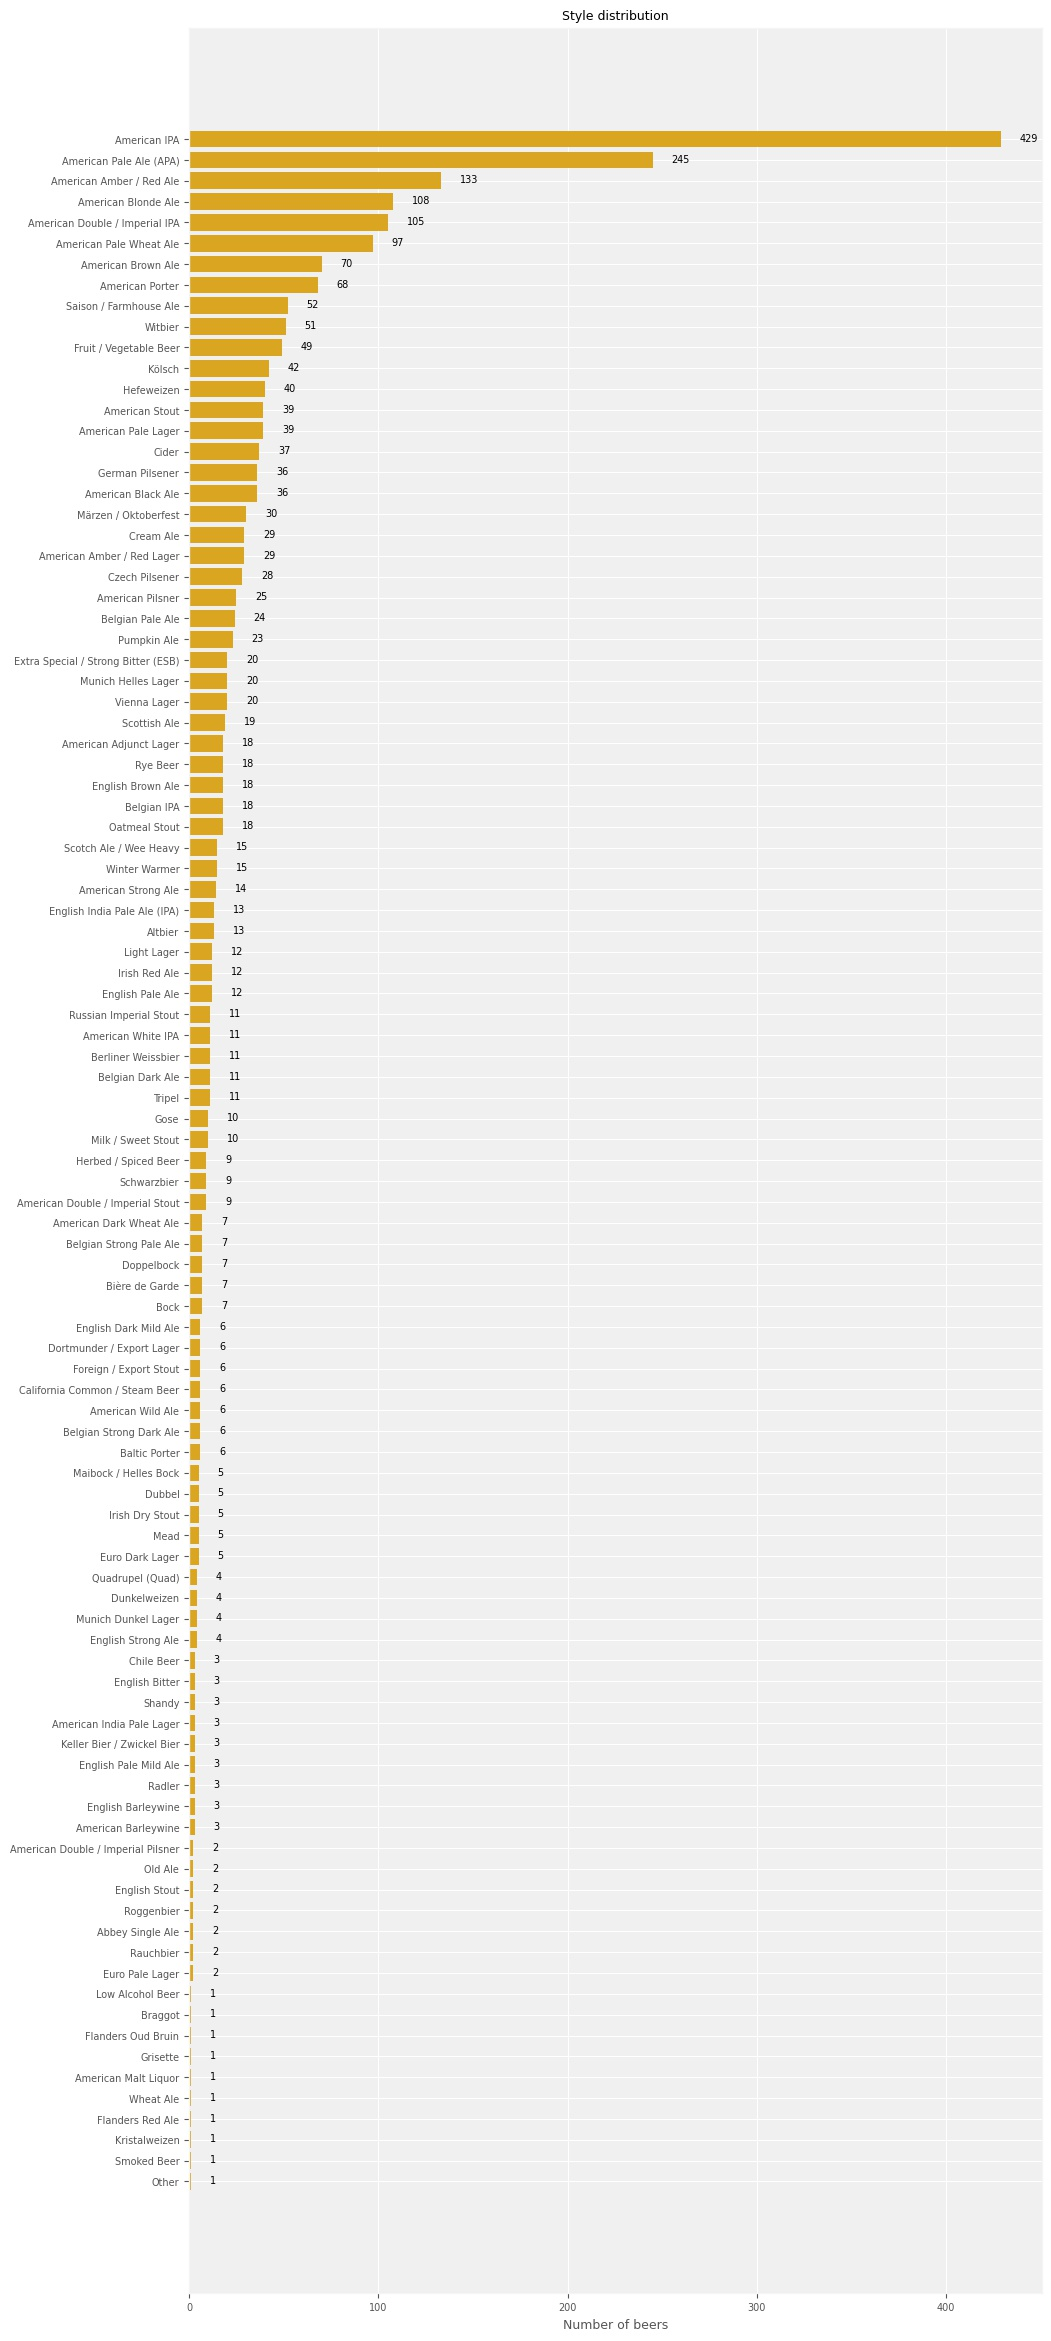

In [8]:
#checking style distributions

styleDict = {}

for ind in dfBeers.index:
    temp = dfBeers['style'][ind]
    if temp not in styleDict:
        styleDict[temp] = 1
    else:
        styleDict[temp] += 1

styles_sorted  = sorted(styleDict.keys(), key=lambda x: styleDict[x])
x = [styleDict[style] for style in styles_sorted]
y = range(len(styles_sorted))
plt.figure(figsize=(11, 30));
plt.barh(y, x, color='goldenrod')
plt.yticks(y);
plt.gca().set_yticklabels(styles_sorted)
#plt.ylim(-0.5, len(styles_sorted)-0.5)
plt.xlabel("Number of beers");
for i in y:
    plt.text(10 + x[i], i-0.1, 
             f"{x[i]}");
plt.title("Style distribution");


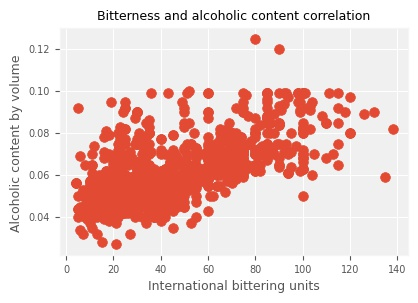

In [9]:
plt.scatter(dfBeers.ibu, dfBeers.abv)
plt.xlabel("International bittering units")
plt.ylabel("Alcoholic content by volume ")
plt.title("Bitterness and alcoholic content correlation");

In [10]:
def pearson(x, y):
    return np.mean(((x - np.mean(x))*(y-np.mean(y)))/(np.std(x)*np.std(y)))

In [11]:
pearson(dfBeers.ibu, dfBeers.abv)

0.6769756239271905

Pearson shows a good positive correlation

In [12]:
top_ten_styles = set(styles_sorted[-10:])

top_beers_df = dfBeers[dfBeers['style'].isin(top_ten_styles)]
bit = []
for bitterness in top_beers_df['ibu']:
    if np.isnan(bitterness):
        bit.append(np.nan)
    elif bitterness <= 50:
        bit.append('Low')
    elif bitterness <= 94:
        bit.append('Medium')
    else:
        bit.append('High')

top_beers_df.insert(len(top_beers_df.columns), "Bitterness", bit, True)
#df.loc[df.Weight == "155", "Name"] = "John"
top_beers_df

,rowNum,abv,ibu,id,name,style,brewery_id,ounces,Bitterness
1,1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0,NaN
2,2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0,NaN
3,3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0,NaN
4,4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0,NaN
6,6,0.045,NaN,2260,Lake Street Express,American Pale Ale (APA),177,12.0,NaN
...,...,...,...,...,...,...,...,...,...
2399,2399,0.069,69.0,1512,Worthy IPA (2013),American IPA,199,12.0,Medium
2400,2400,0.060,50.0,1511,Worthy Pale,American Pale Ale (APA),199,12.0,Low
2406,2406,0.052,NaN,807,Rail Yard Ale,American Amber / Red Ale,424,12.0,NaN
2408,2408,0.055,40.0,145,Silverback Pale Ale,American Pale Ale (APA),424,12.0,Low


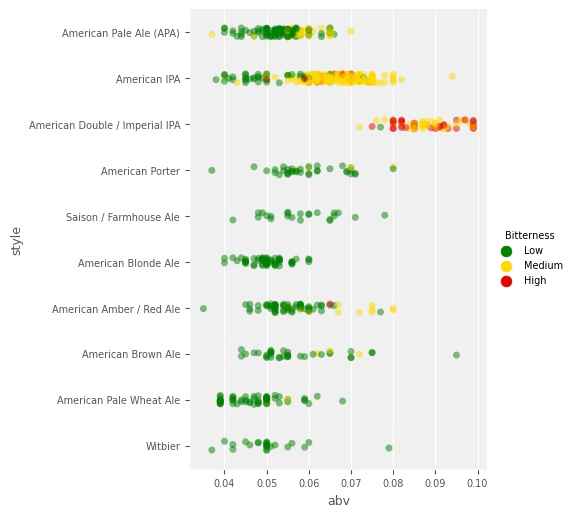

In [13]:
ax = sns.catplot(y="style", x="abv", jitter=True, data=top_beers_df, hue="Bitterness", 
                 palette=[(0, 0.5, 0), (1, 0.85, 0), (0.9, 0, 0)], legend=True, 
                 hue_order= ["Low", "Medium", "High"], alpha=0.5);

In [14]:
#Grouping states into regions

northEastArr = set(["ME","MA","RI", "CT", "NH", "VT", "NY", "PA", "NJ", "DE", "MD"])
southEastArr = set(["WV","VA", "KY", "TN", "NC", "SC", "GA", "AL", "MS", "AR", "LA", "FL"])
midWestArr = set(["OH", "IN", "MI", "IL", "MS", "WI", "MN", "IA", "KS", "NE", "SD", "ND"])
southWestArr = set(["TX", "OK", "NM", "AZ"])
westArr = set(["CO", "WY", "MT", "ID", "WA", "OR", "UT", "NV", "CA", "AK", "HI"])

northEastBrewers = dfBrewers[dfBrewers['state'].isin(northEastArr)]['brewery_id']
southEastBrewers = dfBrewers[dfBrewers['state'].isin(southEastArr)]['brewery_id']
midWestBrewers = dfBrewers[dfBrewers['state'].isin(midWestArr)]['brewery_id']
southWestBrewers = dfBrewers[dfBrewers['state'].isin(southWestArr)]['brewery_id']
westBrewers = dfBrewers[dfBrewers['state'].isin(westArr)]['brewery_id']

NE_Beers = dfBeers[dfBeers['brewery_id'].isin(northEastBrewers)]
SE_Beers = dfBeers[dfBeers['brewery_id'].isin(southEastBrewers)]
MW_Beers = dfBeers[dfBeers['brewery_id'].isin(midWestBrewers)]
SW_Beers = dfBeers[dfBeers['brewery_id'].isin(southWestBrewers)]
W_Beers = dfBeers[dfBeers['brewery_id'].isin(westBrewers)]

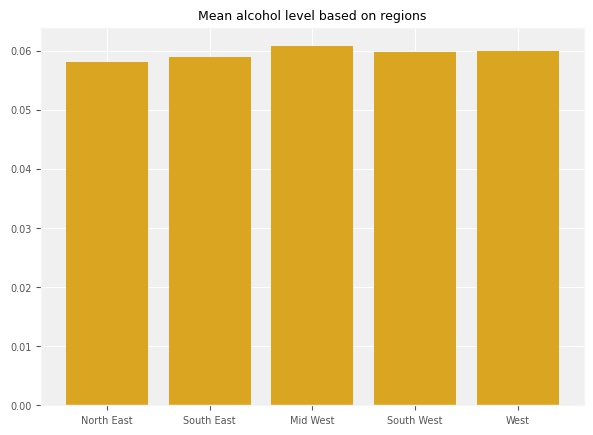

In [15]:
#checking mean alcohol level based on region
xAxis = ['North East', 'South East', 'Mid West', 'South West', 'West']
yAxis = [NE_Beers['abv'].mean(), SE_Beers['abv'].mean(), MW_Beers['abv'].mean(), SW_Beers['abv'].mean(), W_Beers['abv'].mean()]

plt.figure(figsize=(7, 5));
plt.bar(xAxis, yAxis, color='goldenrod')
plt.title("Mean alcohol level based on regions");

There does not seem to be much of a difference in alcohol levels between regions.

Now we'll illustrate the most popular beer styles in each region

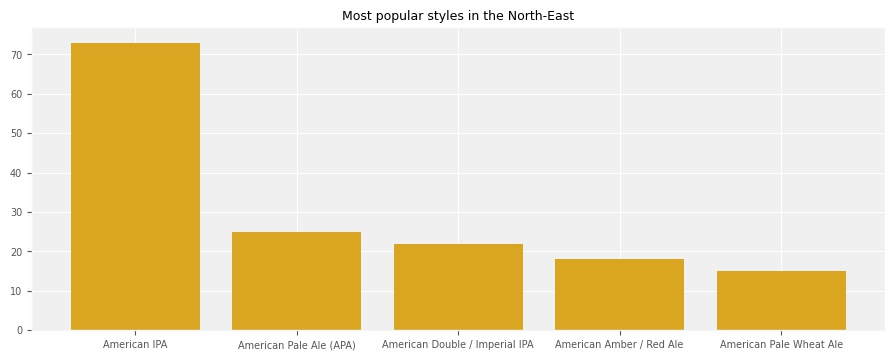

In [16]:
#North-East
s = NE_Beers['style'].value_counts()[:5]
yAxis = s.tolist()
xAxis = s.index.tolist()

plt.figure(figsize=(11, 4));
plt.bar(xAxis, yAxis, color='goldenrod')
plt.title("Most popular styles in the North-East");

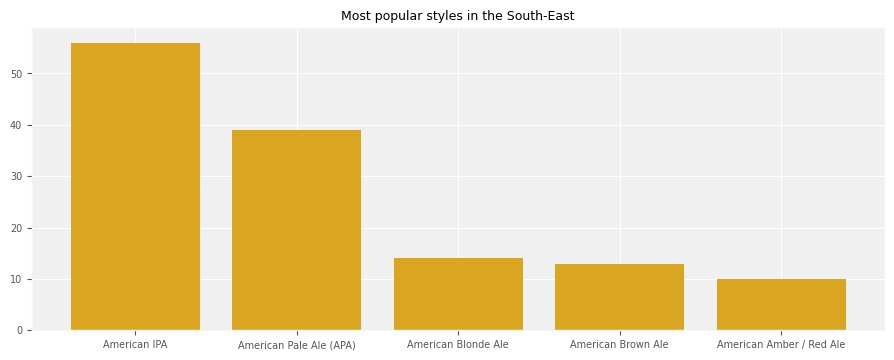

In [17]:
#South-East
s = SE_Beers['style'].value_counts()[:5]
yAxis = s.tolist()
xAxis = s.index.tolist()

plt.figure(figsize=(11, 4));
plt.bar(xAxis, yAxis, color='goldenrod')
plt.title("Most popular styles in the South-East");

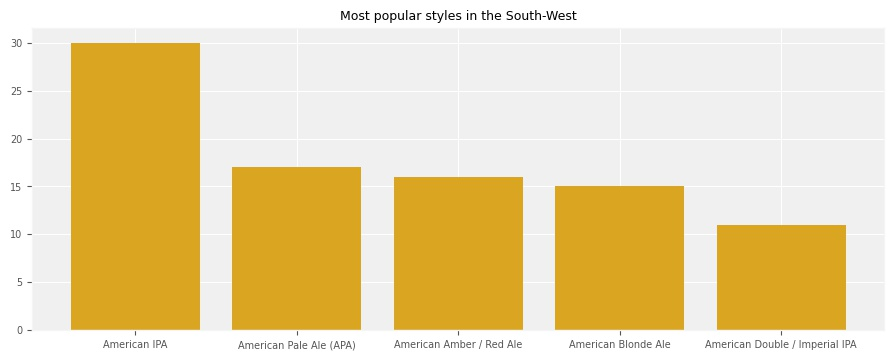

In [18]:
#South-West
s = SW_Beers['style'].value_counts()[:5]
yAxis = s.tolist()
xAxis = s.index.tolist()

plt.figure(figsize=(11, 4));
plt.bar(xAxis, yAxis, color='goldenrod')
plt.title("Most popular styles in the South-West");

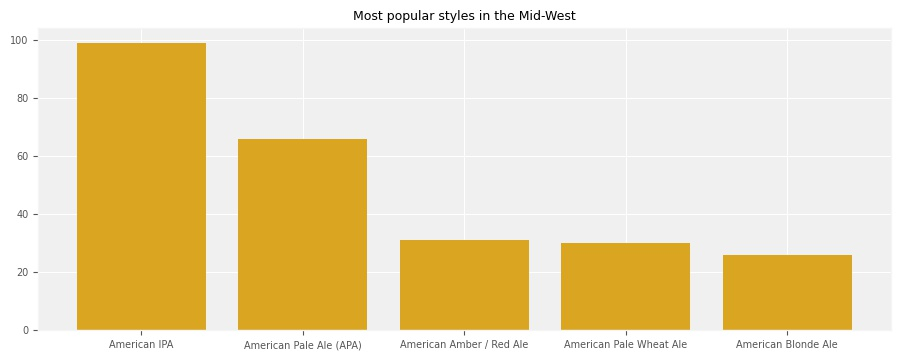

In [19]:
#Mid-West
s = MW_Beers['style'].value_counts()[:5]
yAxis = s.tolist()
xAxis = s.index.tolist()

plt.figure(figsize=(11, 4));
plt.bar(xAxis, yAxis, color='goldenrod')
plt.title("Most popular styles in the Mid-West");

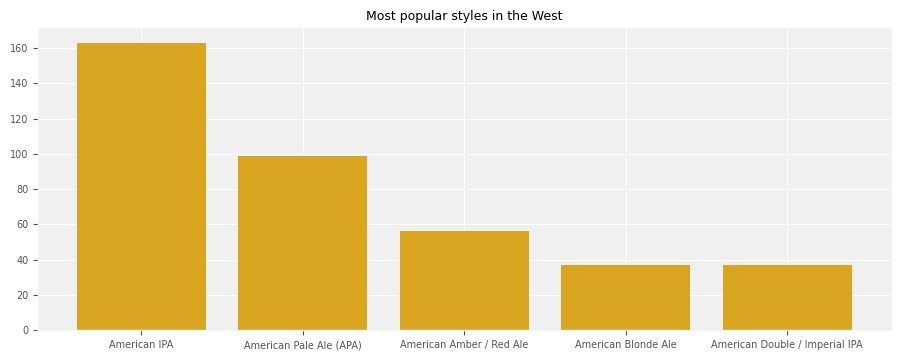

In [20]:
#West
s = W_Beers['style'].value_counts()[:5]
yAxis = s.tolist()
xAxis = s.index.tolist()

plt.figure(figsize=(11, 4));
plt.bar(xAxis, yAxis, color='goldenrod');
plt.title("Most popular styles in the West");

In [21]:
#Distributions for bitterness and alcohol levels of each beer

bitterness = []
alcoholLevels = []
for name in set(dfBeers["name"]):
    ibu = [x for x in dfBeers["ibu"][dfBeers["name"]==name] if np.isnan(x)==False]
    abv = [x for x in dfBeers["abv"][dfBeers["name"]==name] if np.isnan(x)==False]
    if (len(ibu)>0):
        bitterness.append(np.mean(ibu))
    if (len(abv)>0):
        alcoholLevels.append(np.mean(abv))

In [22]:
from scipy.stats import beta
import warnings
warnings.filterwarnings('ignore')

def betaDistribution(a, b, samples, labels):
    for i in range(len(samples)):
        sample = samples[i]
        xr = np.linspace(0, np.max(sample), 100)     
        parameters_Beta = beta.fit(sample)
        P_fit_Beta = [beta.pdf(x, *parameters_Beta) for x in xr]
        if (i%2==0):
            plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, int(i%2)+1)
        plt.hist(sample,    label="Sample", density=True)
        plt.plot(xr, P_fit_Beta, label="Model", linewidth=2.0)
        plt.title("Beta distribution for "+labels[i])
        plt.legend()
        if ((i-1)%2==0 and i>0):
            plt.show()
    plt.show()

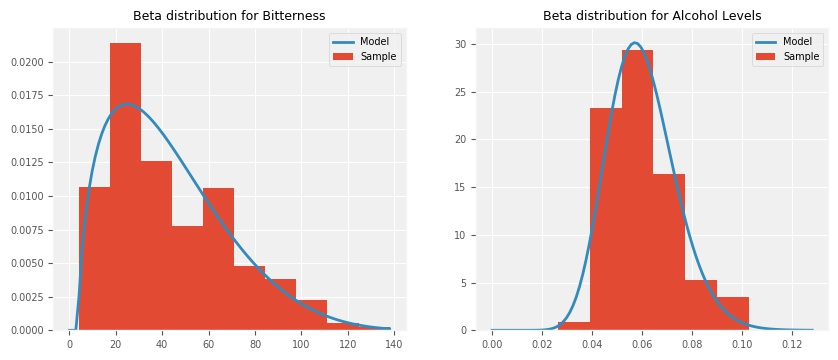

In [23]:
betaDistribution(0, 1, [bitterness, alcoholLevels], ["Bitterness", "Alcohol Levels"])

## Imputation of data

Because many values from **ibu** are missing we need to use some kind on an imputation. The case of the missing values was not provided in the description, so we assume that the values are most likey *missing completly at random*, or *missing at random*. In this case we try to model the *bitterness units* (**ibu**) with multiple regression models and choose the one that best fits the data, and use it to predict the **NaN** values.

In [24]:
#fixing missing ibu values
#We use multiple imputation with MICE

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer

#Create numpy array from dataframe and remove categorical data
arrBeers = dfBeers.to_numpy()
arrBeers = np.delete(arrBeers, 4, 1)
#arrBeers = np.delete(arrBeers, 4, 1)

print(arrBeers[:,5])

#arrBeers = imp.fit_transform(arrBeers)

[408 177 177 ... 424 424 424]


In [25]:
encoder = OneHotEncoder(handle_unknown='ignore')
styles_np = arrBeers[:,[4]]
encoder_fit = encoder.fit(styles_np)
styles_encoded = encoder.transform(styles_np).toarray()

from categorical to boolean vecors (algorithms do not work with nominal and categorical values).

In [26]:
brew_id = arrBeers[:, [5]]
encoder = OneHotEncoder(handle_unknown='ignore').fit(brew_id)
brew_id_transformed = encoder.transform(brew_id).toarray()

In [27]:
brew_id_transformed.shape, len(set(dfBeers['brewery_id']))

((2410, 558), 558)

In [28]:
arrBeers = np.delete(arrBeers, 4, 1)
arrBeers = np.delete(arrBeers, 0, 1)
arrBeers = np.delete(arrBeers, 2, 1)
arrBeers = np.delete(arrBeers, 2, 1)

deleting the values that are directly connected to the beer (ids, etc).

In [29]:
arrBeers = np.concatenate((arrBeers, styles_encoded), axis=1)
arrBeers = np.concatenate((arrBeers, brew_id_transformed), axis=1)

In [30]:
#arrBeers = imp.fit_transform(arrBeers)
arrBeers = arrBeers.astype('float')
arrBeers_filtered = arrBeers[~np.isnan(arrBeers[:,1]),:]
#train, test = shuffle_and_split(arrBeers_filtered)

In [31]:
def shuffle_and_split(data):
    np.random.shuffle(data)
    train, test = data[:round(0.75 * data.shape[0]),:], data[round(0.75 * data.shape[0]):,:]
    return train, test

Data is split in 75% -25% learning, testing set. ** why we chose this ....**

In [32]:
def make_models(data, models):
    from collections import defaultdict
    result = defaultdict(list)
    train, test = shuffle_and_split(data)
    y_train = train[:, 1]
    X_train = np.delete(train, 1, 1)
    
    for model in models:
        results_model = []
        model.fit(X_train, y_train)
        X_test = np.delete(test, 1, 1)
        y_test = test[:, 1]
        y_pred = model.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        result[model].append((rmse, r2))
    return result

In [33]:
def get_results(data, models):
    from collections import defaultdict
    results = defaultdict(dict)
    for i in range(4):
        results[i] = make_models(data, models)
    return results

The experiments are repeated 4 times....

In [34]:
def mean_from_results(results, models):
    for model in models:
        mean_rmse = []
        mean_r2 = []
        for experiment in range(4):
            r2_score = [r2 for _, r2 in results[experiment][model]]
            rmse = [rmse for rmse, _ in results[experiment][model]]
            mean_rmse.append(np.mean(rmse))
            mean_r2.append(np.mean(r2_score))
        print(f"{str(model):>10} {np.mean(mean_rmse) :>.3f} {np.mean(mean_r2) :>.3f}")

In [35]:
model_basic_lin = LinearRegression()
model_lasso = Lasso(alpha=1)
model_ridge = Ridge(alpha=1)
model_rnd_forest = RandomForestRegressor()
models = [model_basic_lin, model_lasso, model_ridge, model_rnd_forest]

In [36]:
#reg_result = make_models(arrBeers_filtered, models)
results = get_results(arrBeers_filtered, models)
mean_from_results(results, models)

LinearRegression() 1105364977494.263 -4093265157633200881664.000
Lasso(alpha=1) 18.297 0.506
Ridge(alpha=1) 13.627 0.725
RandomForestRegressor() 11.947 0.789


From all the models *Random forest regressor* works the best with $ R^2 $ = 0.789 and ***RMSE*** = 11.760 (average values of four repeated experiments.)

In [37]:
arrBeers_NaN = arrBeers[np.isnan(arrBeers[:,1])]
arrBeers_NaN = np.delete(arrBeers_NaN, 1, 1)
y = arrBeers_filtered[:, 1]
X = np.delete(arrBeers_filtered, 1, 1)
model_rnd_forest.fit(X, y)
predicted_bitterness = model_rnd_forest.predict(arrBeers_NaN)

In [38]:
np.mean(predicted_bitterness)

35.828085406301824

In [39]:
#dfBeers[np.isnan(dfBeers["ibu"])].replace(predicted_bitterness, inplace=True)
dfBeers.loc[np.isnan(dfBeers["ibu"]), "ibu"] = predicted_bitterness

In [40]:
dfBeers

,rowNum,abv,ibu,id,name,style,brewery_id,ounces
0,0,0.050,21.33,1436,Pub Beer,American Pale Lager,408,12.0
1,1,0.066,59.96,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,2,0.071,70.20,2264,Rise of the Phoenix,American IPA,177,12.0
3,3,0.090,84.52,2263,Sinister,American Double / Imperial IPA,177,12.0
4,4,0.075,77.74,2262,Sex and Candy,American IPA,177,12.0
...,...,...,...,...,...,...,...,...
2405,2405,0.067,45.00,928,Belgorado,Belgian IPA,424,12.0
2406,2406,0.052,22.58,807,Rail Yard Ale,American Amber / Red Ale,424,12.0
2407,2407,0.055,23.91,620,B3K Black Lager,Schwarzbier,424,12.0
2408,2408,0.055,40.00,145,Silverback Pale Ale,American Pale Ale (APA),424,12.0


The dataframe we replaced NaN ibu with predictions from the random forest model.

In [41]:
import Orange
import scipy.cluster.hierarchy as sch
import scipy
from sklearn.metrics import silhouette_score
from collections import defaultdict

from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

Because there are way to many types of beers, we split them by regions for clustering.

In [42]:
#makes the matrix for the beers
def init_matrix(dataset):
    names = sorted(list(set(dataset["name"])))
    styles = sorted(list(set(dataset["style"])))
    breweryID = sorted(list(set(dataset["brewery_id"])))
    matrix = []
    for name in names:
        row = []
        ibu = np.mean(dataset["ibu"][dataset["name"]==name])
        abv = np.mean(dataset["abv"][dataset["name"]==name])
        if (np.isnan(ibu)):  #uncomment these lines for -1 instead of NaN for ibu and abv
            row.append(np.nan)
        else:
            row.append(ibu)
        if (np.isnan(abv)):
            row.append(np.nan)
        else:
            row.append(abv)
        style = [x for x in set(dataset["style"][dataset["name"]==name])][0]
        for s in styles:
            if style==s:
                row.append(1)
            else:
                row.append(0)
        bid = [x for x in set(dataset["brewery_id"][dataset["name"]==name])][0]
        for b in breweryID:
            if bid==b:
                row.append(1)
            else:
                row.append(0)
        matrix.append(row)
    return matrix, names

def draw_clusters(matrix, dataset, method, metric, t):
    L = sch.linkage(np.array(matrix), method=method, metric=metric)
    predictions = sch.fcluster(L, t=t, criterion="distance").ravel()
    classes     = np.array(matrix).ravel()
    
    plt.figure(figsize=(25, 6))
    names = sorted(list(set(dataset["name"])))
    labels = [name for name in names]
    D      = sch.dendrogram(L, labels=labels, leaf_font_size=15);
    plt.plot([0, len(dataset)*10], [t, t], "k--")
    plt.ylabel("Razdalja")
    plt.show()
    return predictions

def score_clusters(matrix, predictions, metric): 
    score = silhouette_score(matrix, predictions, metric=metric)
    #score = calinski_harabasz_score(matrix,predictions)
    #score = davies_bouldin_score(matrix,predictions)
    return score

In [43]:
def getState(state):
    bid = dfBrewers["brewery_id"][dfBrewers["state"]==state]
    return dfBeers[dfBeers["brewery_id"].isin(bid)]

In [44]:
#get clusters as dictionary
def get_separate_clusters(linkage, names):
    groups_by_names = defaultdict(list)
    for group, name in zip(linkage, names):
        groups_by_names[group].append(name)
    return groups_by_names

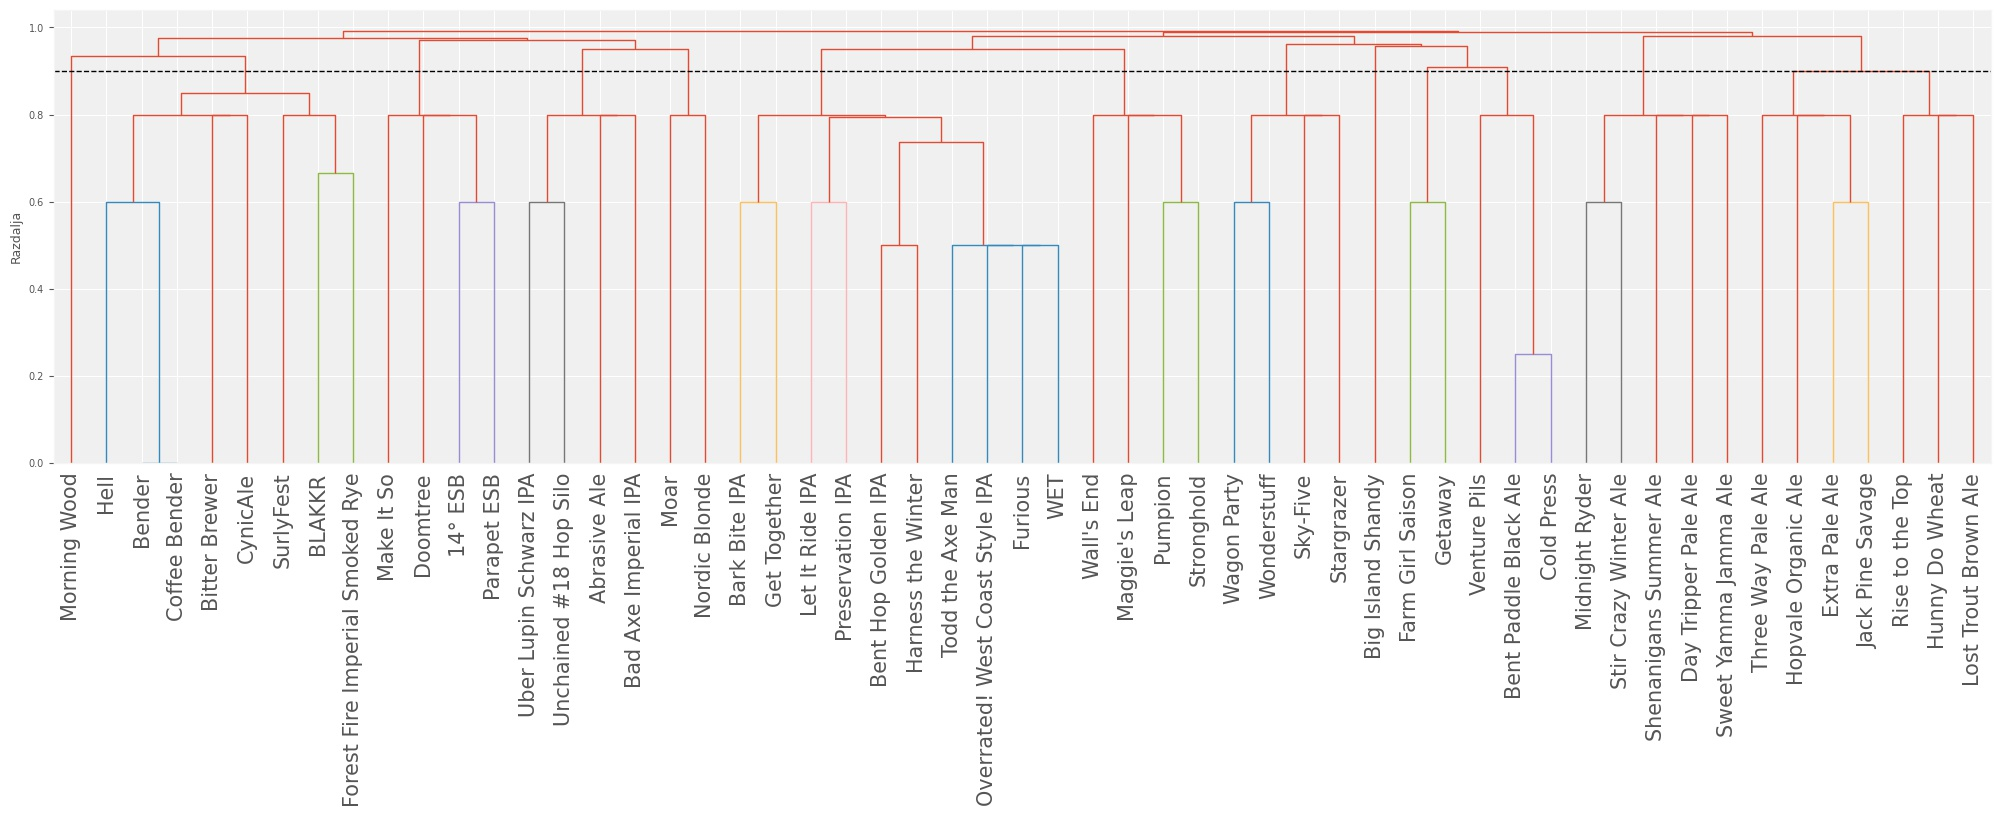

In [45]:
#State clusters
state = getState("MN")
clusters, names = init_matrix(state)
linkage = draw_clusters(clusters, state, "weighted", "jaccard", 0.9)

In [46]:
score_clusters(clusters, linkage, "jaccard")

0.20852024188081725

In [47]:
data_matrix, beer_names = init_matrix(dfBeers)

In [48]:
groups_by_names = get_separate_clusters(linkage, names)
groups_by_names

defaultdict(list,
            {3: ['14° ESB', 'Doomtree', 'Make It So', 'Parapet ESB'],
             4: ['Abrasive Ale',
              'Bad Axe Imperial IPA',
              'Uber Lupin Schwarz IPA',
              'Unchained #18 Hop Silo'],
             1: ['BLAKKR',
              'Bender',
              'Bitter Brewer',
              'Coffee Bender',
              'CynicAle',
              'Forest Fire Imperial Smoked Rye',
              'Hell',
              'SurlyFest'],
             6: ['Bark Bite IPA',
              'Bent Hop Golden IPA',
              'Furious',
              'Get Together',
              'Harness the Winter',
              'Let It Ride IPA',
              'Overrated! West Coast Style IPA',
              'Preservation IPA',
              'Todd the Axe Man',
              'WET'],
             10: ['Bent Paddle Black Ale', 'Cold Press', 'Venture Pils'],
             11: ['Big Island Shandy'],
             12: ['Day Tripper Pale Ale',
              'Midnight Ryder',


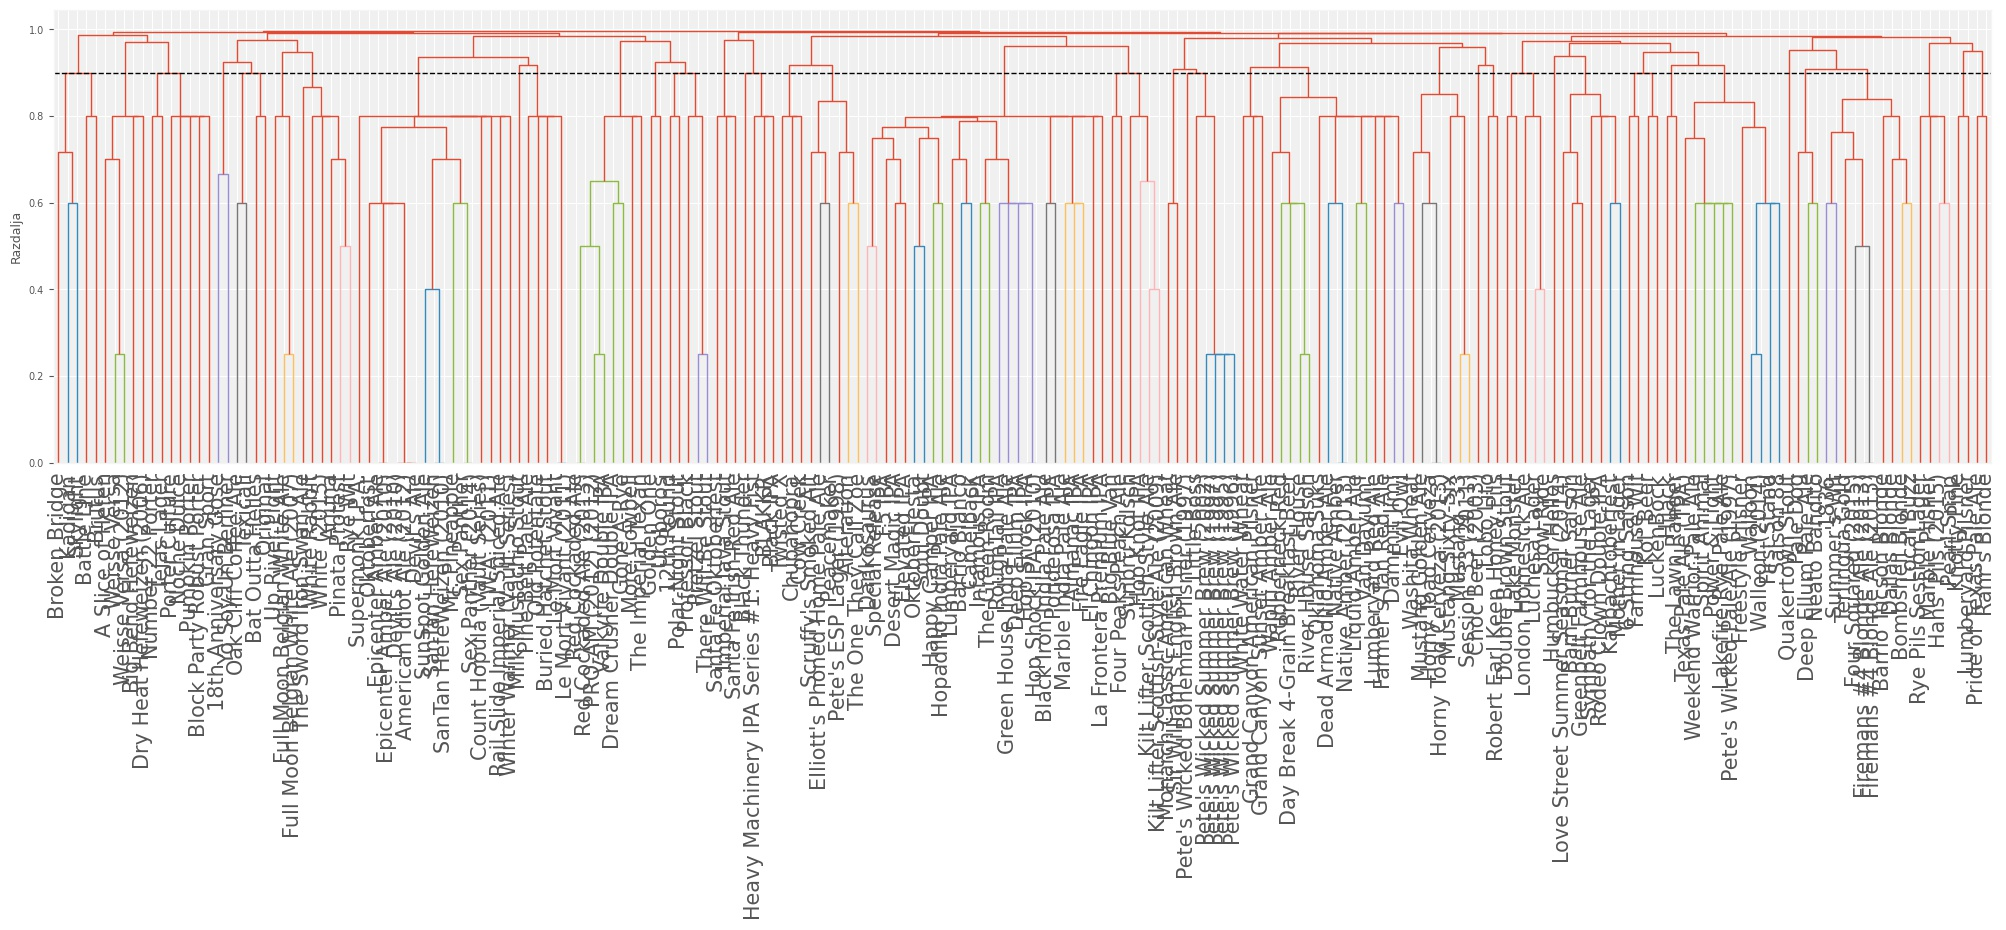

In [49]:
# South-West region clusters
clusters, names = init_matrix(SW_Beers)
linkage = draw_clusters(clusters, SW_Beers, "weighted", "jaccard", 0.9)

In [50]:
clusters, names = init_clusters(SW_Beers)
linkage = draw_clusters(clusters, SW_Beers, "complete", "jaccard", 0.9)

NameError: name 'init_clusters' is not defined

In [ ]:
score_clusters(clusters, linkage, "jaccard")